# Multi Resolution Simulation

### Classes and modules

In [23]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [24]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [25]:
%cuda_context_handler gpu_ctx

Rossby utils

In [26]:
# %%
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
sys.path.insert(0, "/home/florianb/havvarsel/multilevelDA/")
from utils.RossbyInit import *
from utils.WindPerturb import *
from utils.RossbyAnalysis import *
from utils.RossbyEnsembleInit import *


## Data Assimilation


In [27]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [28]:
def imshow3var(est_var):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(est_var[0], vmin=0.0, vmax=0.00025, cmap="Reds")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(est_var[1], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(est_var[2], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    # fig.suptitle("ML variance", y=0.9)

    return fig, axs

In [29]:
wind_N = 100
t_splits = 26

KLSampler = KarhunenLoeve_Sampler(t_splits + 3, wind_N, decay=1.15, scaling=0.9)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

In [30]:
vars_file = "../scripts/OutputVarianceLevels/2023-02-24T16_29_26_Rossby/vars.npy"
diff_vars_file = "../scripts/OutputVarianceLevels/2023-02-24T16_29_26_Rossby/diff_vars.npy"

In [31]:
ls = [6, 7, 8, 9, 10]

In [32]:
T = 125000
T_forecast = 12500

In [33]:
rossbyAnalysis = RossbyAnalysis(ls, vars_file, diff_vars_file)
ML_Nes = rossbyAnalysis.optimal_Ne(tau=2.0*1e-7)
ML_Nes

array([5193,  189,   51,   14,    6], dtype=int32)

In [34]:
def generate_truth():
    data_args = initLevel(ls[-1])
    true_wind = wind_sample(KLSampler, T + T_forecast, wind_weight=wind_weight, wind_speed=0.0)
    truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)

    return truth

def generate_obs_from_truth(truth, Hy, Hx, R):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

    Hfield = np.zeros((truth.ny,truth.nx))
    
    Hfield[Hy,Hx] = 1.0

    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

    return obs

#ML_ensemble = initMLensemble(gpu_ctx, ls, ML_Nes, KLSampler, wind_weight, T + T_forecast, 0.0)


Hy, Hx = 600, 800
#R = [0.0001, 0.01, 0.01]
R = [0,0,0]

### Truth

[-0.00070405  0.01387017  0.18611471]


Text(0.5, 0.85, 'Truth')

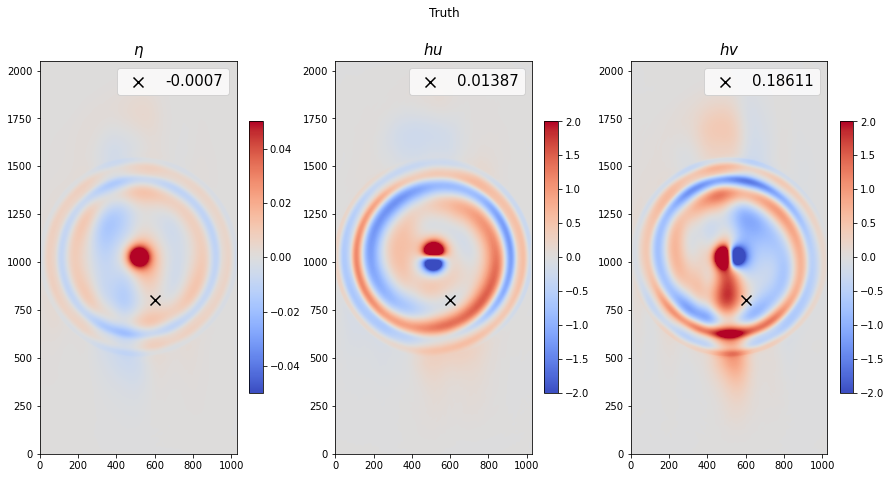

In [35]:
truth = generate_truth()
truth.step(T)
obs = generate_obs_from_truth(truth, Hy, Hx, R)

print(obs)

fig, axs = imshow3(truth.download())
axs[0].scatter(Hy,Hx, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)

In [36]:
# obs = np.array([-0.00148674, -0.5303819,  0.03913767])

### Analyse ML estimators

In [37]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
from gpuocean.dataassimilation import MLEnKFOcean

In [38]:
# ML_ensemble = initMLensemble(gpu_ctx, ls, ML_Nes, KLSampler, wind_weight, T + T_forecast, 0.0)
# MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

# MLOceanEnsemble.step(T)

# timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
# np.save(str(timestamp)+"dumpMLensemble0", MLOceanEnsemble.download()[0])
# for l in range(1, len(ls)):
#     np.save(str(timestamp)+"dumpMLensemble"+str(l)+"_0", MLOceanEnsemble.download()[l][0])
#     np.save(str(timestamp)+"dumpMLensemble"+str(l)+"_1", MLOceanEnsemble.download()[l][1])

# imshow3(MLOceanEnsemble.estimate(np.mean))

Load state from disc (generation takes 5-15min)

In [39]:
ML_state = []
ref_timestamp = "2023-02-28T16_44_51"
ML_state.append(np.load(ref_timestamp+"dumpMLensemble0.npy"))
for l_idx in range(1,len(ls)):
    ML_state.append([np.load(ref_timestamp+"dumpMLensemble"+str(l_idx)+"_0.npy"),np.load(ref_timestamp+"dumpMLensemble"+str(l_idx)+"_1.npy")])

In [40]:
ML_Nes = np.zeros(len(ML_state), dtype=np.int32)
ML_Nes[0] = ML_state[0].shape[-1]
for l_idx in range(1,len(ML_state)):
    ML_Nes[l_idx] = ML_state[l_idx][0].shape[-1]

In [41]:
ls = np.array(ls)

dxs = 2**(18-ls)*100
dys = 2**(18-ls)*100

nxs = 2**ls
nys = 2**(ls+1)

Analyse ML mean

In [42]:
def MLmean(state):
    MLest_mean = np.zeros(state[-1][0].shape[:-1])
    MLest_mean += np.average(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_mean += np.average(state[l_idx][0] - state[l_idx][1].repeat(2,1).repeat(2,2), axis=-1).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)

    return MLest_mean

Text(0.5, 0.85, 'ML mean')

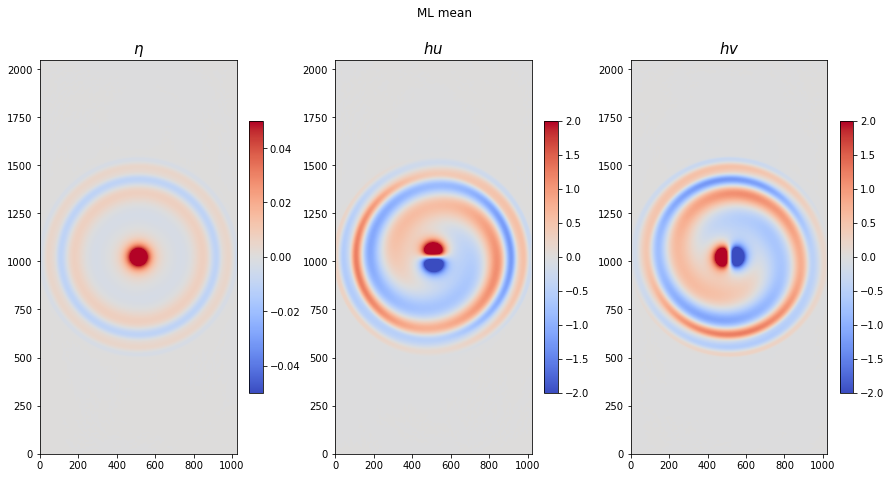

In [43]:
fig, axs = imshow3(MLmean(ML_state))
fig.suptitle("ML mean", y=0.85)

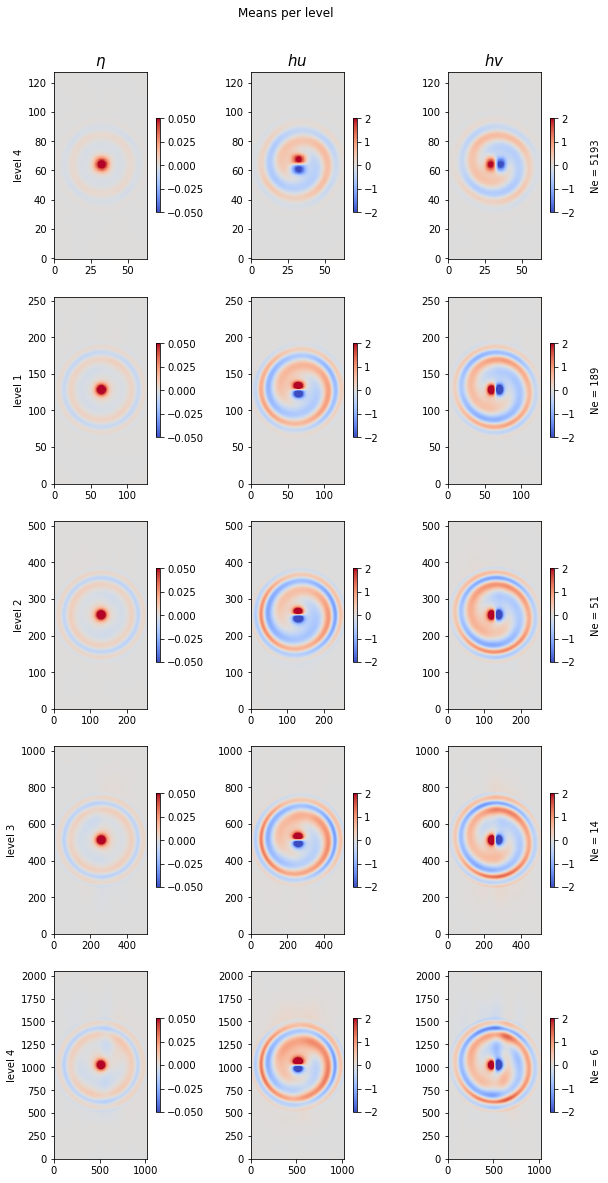

In [44]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Means per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.mean(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.mean(ML_state[l_idx][0],axis=-1)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

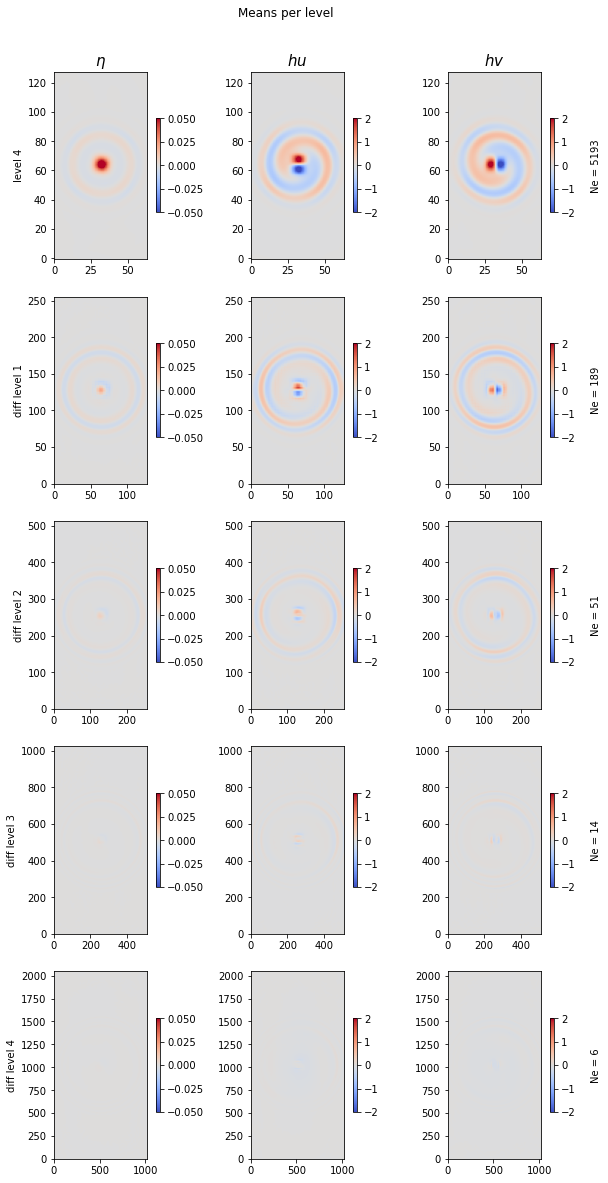

In [45]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Means per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.mean(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.mean(ML_state[l_idx][0],axis=-1) - np.mean(ML_state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

Analyse ML variance

In [46]:
def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var

Text(0.5, 0.85, 'ML var')

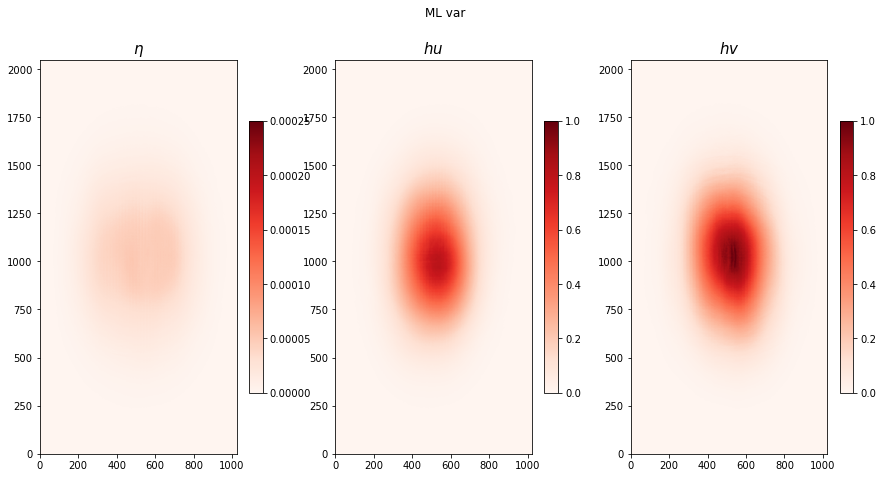

In [47]:
fig, axs = imshow3var(MLvar(ML_state))
fig.suptitle("ML var", y=0.85)

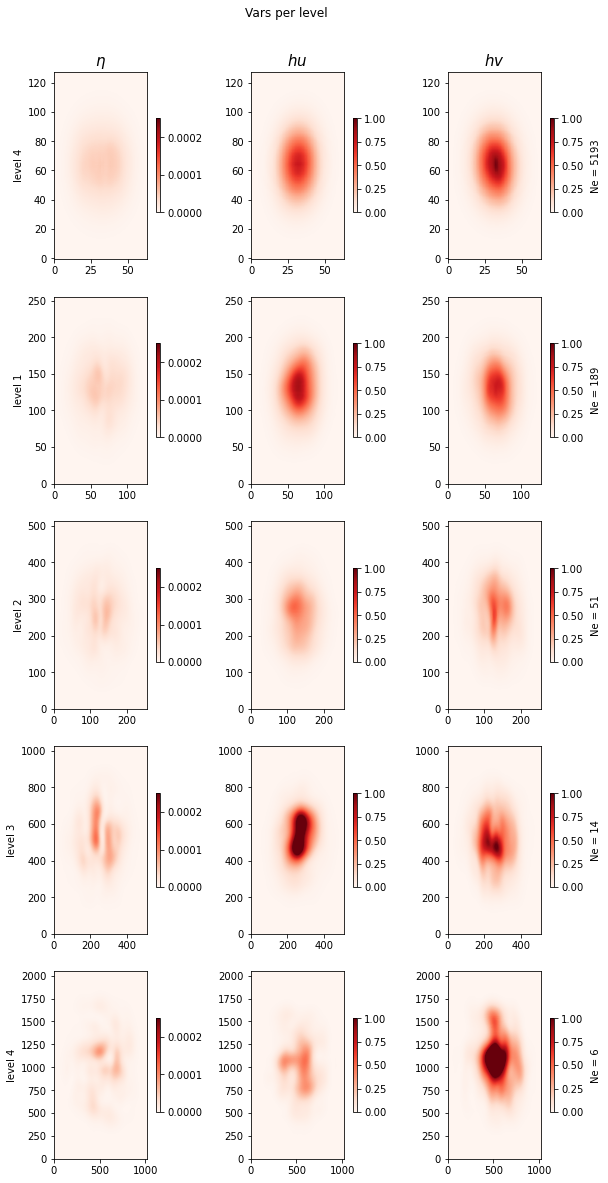

In [48]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Vars per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.var(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=0.0, vmax=0.00025, cmap="Reds")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.var(ML_state[l_idx][0],axis=-1)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=0.0, vmax=0.00025, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

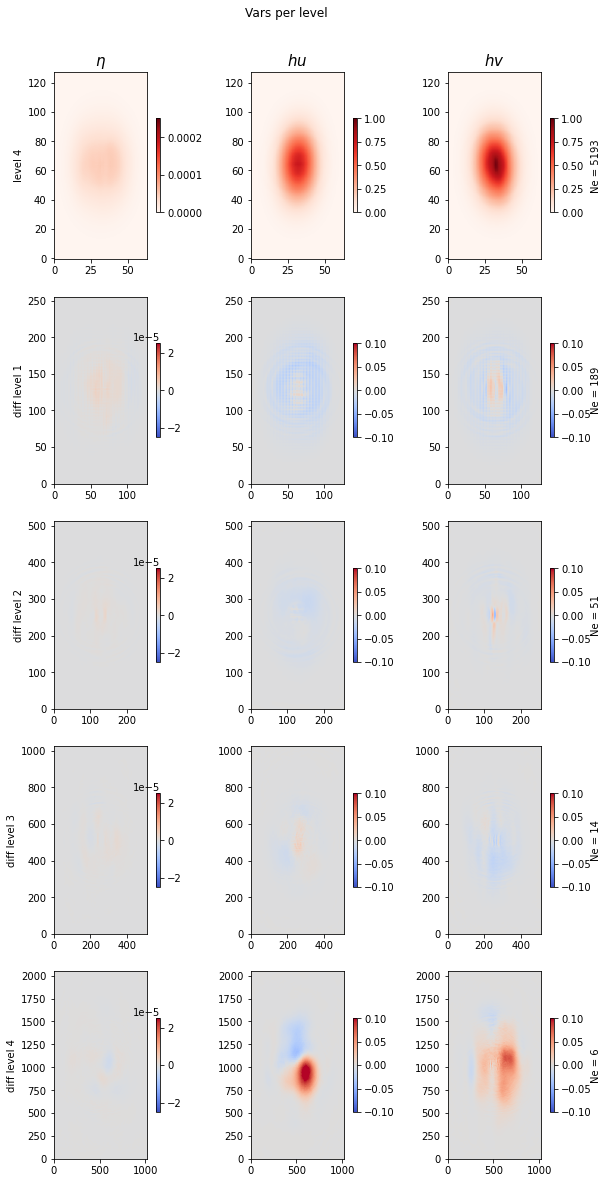

In [49]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Vars per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.var(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=0.0, vmax=0.00025, cmap="Reds")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.var(ML_state[l_idx][0],axis=-1) - np.var(ML_state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-0.000025, vmax=0.000025, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-0.1, vmax=0.1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-0.1, vmax=0.1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

Analyse ML rank histos 


WITHOUT OBSERVATION ERROR

In [50]:
def MLcdf4true(truth, Hx, Hy, ML_state, download=True):
    Nes = np.zeros(len(ML_state), dtype=np.int32)
    Nes[0] = ML_state[0].shape[-1]
    for l_idx in range(1,len(ML_state)):
        Nes[l_idx] = ML_state[l_idx][0].shape[-1]

    if download:
        true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    else:
        true_eta, true_hu, true_hv = truth
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]]) #+ np.random.normal(0,R)

    Xs = np.linspace(0, nxs[-1] * dxs[-1], nxs[-1])
    Ys = np.linspace(0, nys[-1] * dys[-1], nys[-1])
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, nxs[0] * dxs[0], nxs[0])
    lvl_Ys = np.linspace(0, nys[0] * dys[0], nys[0])
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

    ML_Fy = 1/Nes[0] * np.sum(ML_state[0][:,obs_idxs[0],obs_idxs[1],:] < true_values[:,np.newaxis], axis=1)

    for l_idx in range(1,len(ls)):
        lvl_Xs0 = np.linspace(0, nxs[l_idx] * dxs[l_idx], nxs[l_idx])
        lvl_Ys0 = np.linspace(0, nys[l_idx] * dys[l_idx], nys[l_idx])
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, nxs[l_idx-1] * dxs[l_idx-1], nxs[l_idx-1])
        lvl_Ys1 = np.linspace(0, nys[l_idx-1] * dys[l_idx-1], nys[l_idx-1])
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        ML_Fy += 1/Nes[l_idx] * np.sum(1 * (ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < true_values[:,np.newaxis]) 
                                       - 1 * (ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1],:] < true_values[:,np.newaxis]), axis=1)
        
    return ML_Fy

In [51]:
# N = 1000
# true_values = np.zeros((N,3))
# for n in range(N):
#     print(n)
#     truth = generate_truth()
#     truth.step(T)
#     true_values[n] = np.array(truth.download(interior_domain_only=True))[:,Hy, Hx]

# np.save("dumpTrueValues",true_values)

In [52]:
# Load true values from disc (generation of 1000 samples takes 1h)
# true_values = np.load("dumpTrueValues.npy")

Load from file with read-only option (generatiion takes 1h, and too big to load fully)

In [53]:
# N = 1000
# truthes = np.zeros((N,3,truth.ny,truth.nx))
# for n in range(N):
#     print(n)
#     truth = generate_truth()
#     truth.step(T)
#     truthes[n] = np.array(truth.download(interior_domain_only=True))
#     del truth

# np.save("dumpTruthes",truthes)

In [54]:
truthes = np.load("dumpTruthes.npy",  mmap_mode='r')

Diagonal comparison

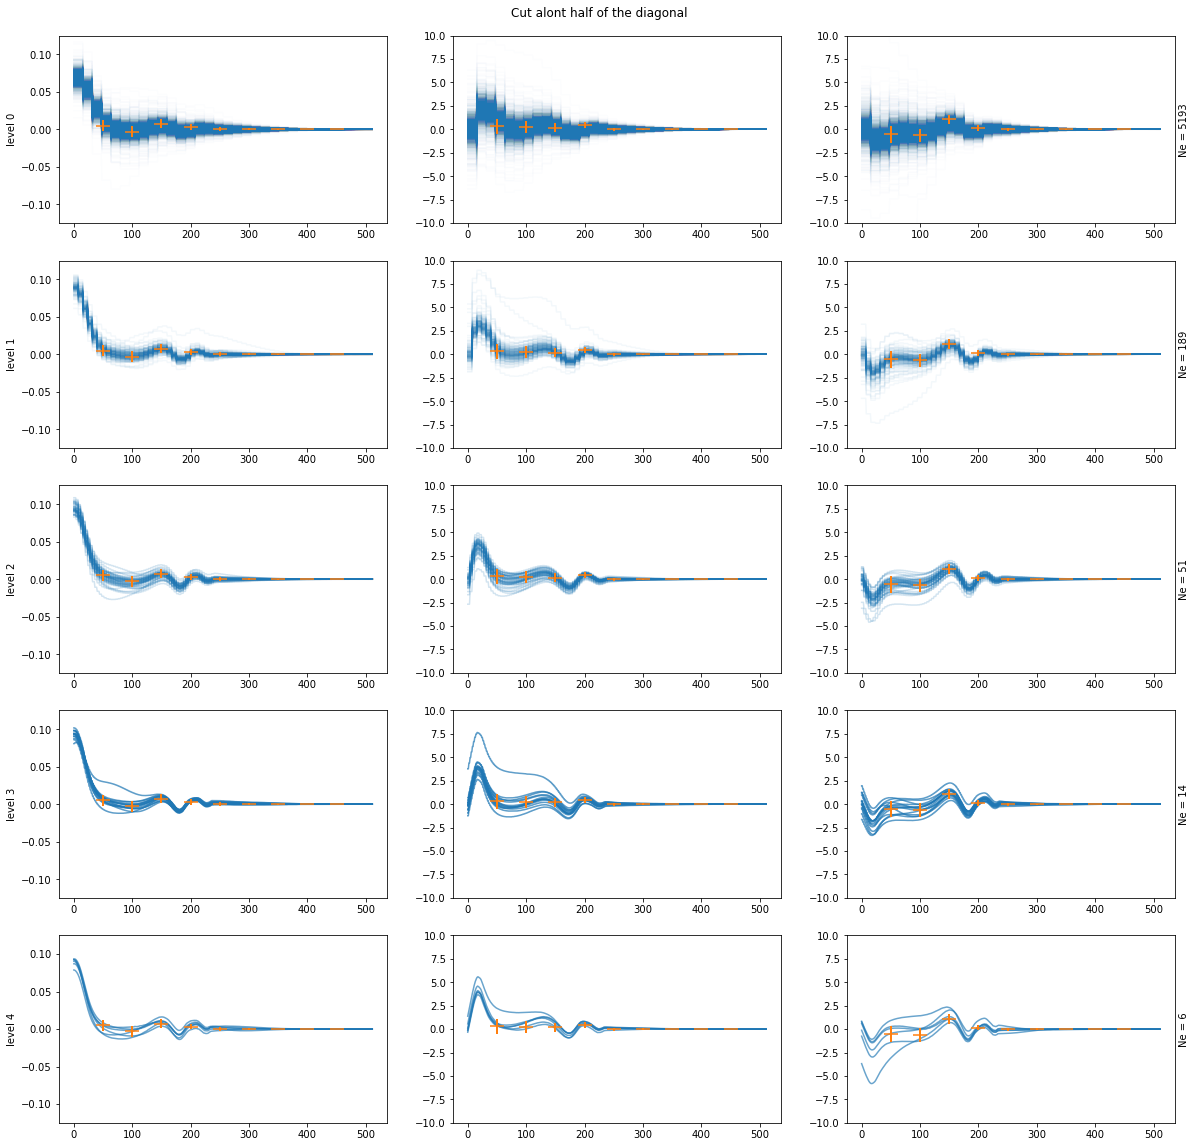

In [55]:
fig, axs = plt.subplots(len(ls),3, figsize=(20,20))
fig.suptitle("Cut alont half of the diagonal",  y=0.9)

# levels
for l_idx in range(len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))

    # level state
    if l_idx == 0:
        l_state = ML_state[0]
    else:
        l_state = ML_state[l_idx][0]


    # eta hu hv
    for v in range(3):
        if v == 0:
            axs[l_idx,v].set_ylim((-0.125,0.125))
        else:
            axs[l_idx,v].set_ylim((-10,10))

        # ensemble member
        for e in range(ML_Nes[l_idx]):
            axs[l_idx,v].plot( np.diag(l_state[v,(2**ls[l_idx])::2,(2**(ls[l_idx]-1))::1,e]).repeat(2**(ls[-1]-ls[l_idx])), alpha=np.maximum(10/ML_Nes[l_idx],0.01), c="C0", zorder=1)

        for diag_loc in range(50,500,50):
            loc_truthes = np.moveaxis(truthes,0,-1)[v,1024+2*diag_loc,512+diag_loc,:]
            low, mean, up = np.quantile(loc_truthes, 0.1), np.mean(loc_truthes),np.quantile(loc_truthes,0.9)
            axs[l_idx,v].scatter(diag_loc, mean, c="C1", marker="_", s=200, zorder=3)
            axs[l_idx,v].vlines(x=diag_loc, ymin=low, ymax=up, colors="C1", lw=2, zorder=2)
    

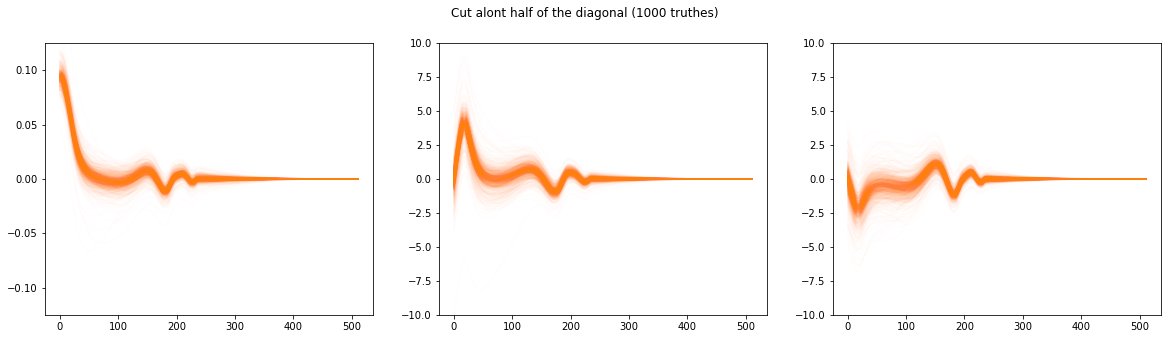

In [56]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle("Cut alont half of the diagonal (1000 truthes)")

# eta hu hv
for v in range(3):
    if v == 0:
        axs[v].set_ylim((-0.125,0.125))
    else:
        axs[v].set_ylim((-10,10))

    # ensemble member
    for e in range(len(truthes)):
        axs[v].plot( np.diag(np.moveaxis(truthes,0,-1)[v,1024::2,512::1,e]), alpha=0.01, c="C1", zorder=1)

Use independent observation indices

In [57]:
newHx, newHy = nxs[-1]-Hx, nys[-1]-Hy

In [58]:
data_args = initLevel(ls[-1])
sim = CDKLM16.CDKLM16(gpu_ctx, **data_args)
sim.step(T)

125000.0

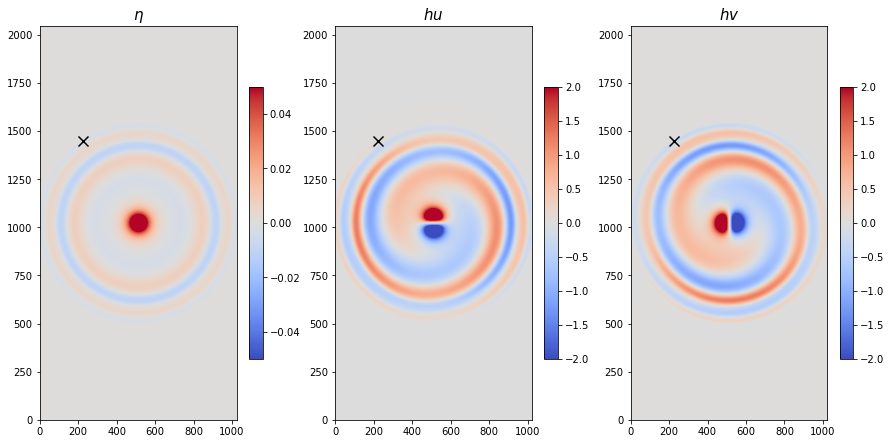

In [61]:
fig, axs = imshow3(np.array(sim.download(interior_domain_only=True)))
axs[0].scatter(newHx, newHy, marker="x", c="black", s=100)
axs[1].scatter(newHx, newHy, marker="x", c="black", s=100)
axs[2].scatter(newHx, newHy, marker="x", c="black", s=100)

ML rank histogram

In [62]:
ML_ranks = np.zeros((len(truthes),3))
for i in range(len(truthes)):
    ML_ranks[i] = MLcdf4true(truthes[i], newHx, newHy, ML_state, download=False)

Text(0.5, 1.0, 'hv')

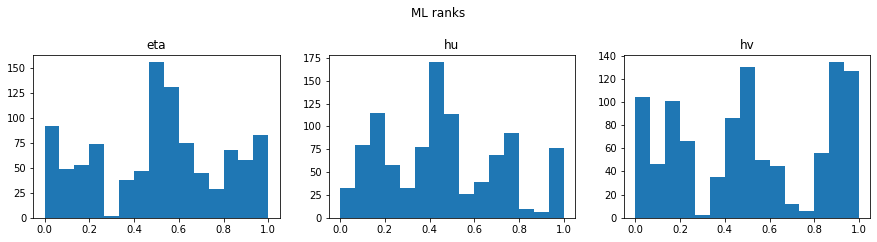

In [63]:

fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ML ranks",y=1.1)

for i in range(3):
    axs[i].hist(np.maximum(0,np.minimum(ML_ranks[:,i],1)), bins=15)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

Ranks per level

In [66]:
ranks_per_level = [] 

lvl_ranks = np.zeros((len(truthes),3))
for i in range(len(truthes)):

    Xs = np.linspace(0, nxs[-1] * dxs[-1], nxs[-1])
    Ys = np.linspace(0, nys[-1] * dys[-1], nys[-1])
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, nxs[0] * dxs[0], nxs[0])
    lvl_Ys = np.linspace(0, nys[0] * dys[0], nys[0])
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,newHx])**2 + (lvl_Y - Y[newHy,0])**2), ML_state[0][0].shape[:-1])

    lvl_ranks[i] = 1/ML_Nes[0] * np.sum(ML_state[0][:,obs_idxs[0],obs_idxs[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis], axis=1)
ranks_per_level.append(lvl_ranks)

for l_idx in range(1, len(ls)):
    lvl_ranks = np.zeros((len(truthes),3))
    for i in range(len(truthes)):
        lvl_Xs0 = np.linspace(0, nxs[l_idx] * dxs[l_idx], nxs[l_idx])
        lvl_Ys0 = np.linspace(0, nys[l_idx] * dys[l_idx], nys[l_idx])
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,newHx])**2 + (lvl_Y0 - Y[newHy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_ranks[i] = 1/ML_Nes[l_idx] * np.sum(ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis], axis=1)
    ranks_per_level.append(lvl_ranks)

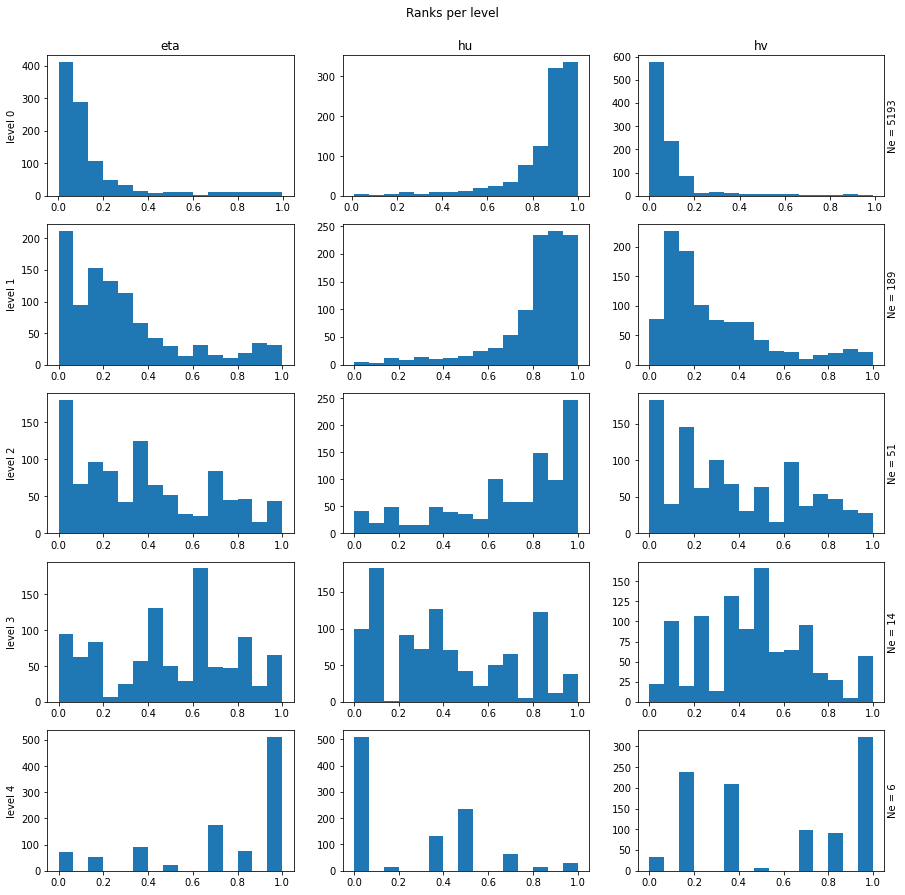

In [67]:
fig, axs = plt.subplots(len(ls), 3, figsize=(15,15))

fig.suptitle("Ranks per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

for l_idx in range(len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))
    for i in range(3):
        axs[l_idx,i].hist(np.maximum(0,np.minimum(ranks_per_level[l_idx][:,i],1)), bins=15)


Analysis

In [ ]:
diff_ranks_per_level = np.zeros((len(ls),len(truthes),3))

for i in range(len(truthes)):

    Xs = np.linspace(0, nxs[-1] * dxs[-1], nxs[-1])
    Ys = np.linspace(0, nys[-1] * dys[-1], nys[-1])
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, nxs[0] * dxs[0], nxs[0])
    lvl_Ys = np.linspace(0, nys[0] * dys[0], nys[0])
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,newHx])**2 + (lvl_Y - Y[newHy,0])**2), ML_state[0][0].shape[:-1])

    diff_ranks_per_level[0][i] = 1/ML_Nes[0] * np.sum(ML_state[0][:,obs_idxs[0],obs_idxs[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis], axis=1)

for l_idx in range(1, len(ls)):
    lvl_ranks = np.zeros((len(true_values),3))
    for i in range(len(true_values)):
        lvl_Xs0 = np.linspace(0, nxs[l_idx] * dxs[l_idx], nxs[l_idx])
        lvl_Ys0 = np.linspace(0, nys[l_idx] * dys[l_idx], nys[l_idx])
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,newHx])**2 + (lvl_Y0 - Y[newHy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, nxs[l_idx-1] * dxs[l_idx-1], nxs[l_idx-1])
        lvl_Ys1 = np.linspace(0, nys[l_idx-1] * dys[l_idx-1], nys[l_idx-1])
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,newHx])**2 + (lvl_Y1 - Y[newHy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        diff_ranks_per_level[l_idx][i] = 1/ML_Nes[l_idx] * ( np.sum(1 * (ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis]), axis=1) 
                                                            - np.sum(1 * (ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis]), axis=1) )


In [ ]:
fig, axs = plt.subplots(len(ls), 3, figsize=(15,15))

fig.suptitle("Ranks per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

for l_idx in range(len(ls)):
    if l_idx == 0:
        axs[l_idx,0].set_ylabel("level "+str(l_idx))
        bins = np.arange(0,1+1e-9,1/15)
        color="C0"
    else: 
        axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
        bins = np.arange(-0.5,0.5+1e-9,1/15)
        color = "C1"
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))
    for i in range(3):
        hist = np.histogram(diff_ranks_per_level[l_idx][:,i], bins=bins)
        axs[l_idx,i].bar(0.5*(hist[1][1:]+hist[1][:-1]),hist[0], width=1/15, color=color)

    

Rank hist over diagonal

In [79]:
freq = 50
Hxs = np.arange( 512, 1024, freq)
Hys = np.arange(1024, 2048, 2*freq)

In [80]:
ML_ranks = np.zeros((len(Hxs)*len(truthes),3))
for j in range(len(Hxs)):
    for i in range(len(truthes)):
        print(j,i)
        ML_ranks[j*len(truthes)+i] += MLcdf4true(truthes[i], Hxs[j], Hys[j], ML_state, download=False)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


1 405
1 406
1 407
1 408
1 409
1 410
1 411
1 412
1 413
1 414
1 415
1 416
1 417
1 418
1 419
1 420
1 421
1 422
1 423
1 424
1 425
1 426
1 427
1 428
1 429
1 430
1 431
1 432
1 433
1 434
1 435
1 436
1 437
1 438
1 439
1 440
1 441
1 442
1 443
1 444
1 445
1 446
1 447
1 448
1 449
1 450
1 451
1 452
1 453
1 454
1 455
1 456
1 457
1 458
1 459
1 460
1 461
1 462
1 463
1 464
1 465
1 466
1 467
1 468
1 469
1 470
1 471
1 472
1 473
1 474
1 475
1 476
1 477
1 478
1 479
1 480
1 481
1 482
1 483
1 484
1 485
1 486
1 487
1 488
1 489
1 490
1 491
1 492
1 493
1 494
1 495
1 496
1 497
1 498
1 499
1 500
1 501
1 502
1 503
1 504
1 505
1 506
1 507
1 508
1 509
1 510
1 511
1 512
1 513
1 514
1 515
1 516
1 517
1 518
1 519
1 520
1 521
1 522
1 523
1 524
1 525
1 526
1 527
1 528
1 529
1 530
1 531
1 532
1 533
1 534
1 535
1 536
1 537
1 538
1 539
1 540
1 541
1 542
1 543
1 544
1 545
1 546
1 547
1 548
1 549
1 550
1 551
1 552
1 553
1 554
1 555
1 556
1 557
1 558
1 559
1 560
1 561
1 562
1 563
1 564
1 565
1 566
1 567
1 568
1 569
1 570
1 57

2 790
2 791
2 792
2 793
2 794
2 795
2 796
2 797
2 798
2 799
2 800
2 801
2 802
2 803
2 804
2 805
2 806
2 807
2 808
2 809
2 810
2 811
2 812
2 813
2 814
2 815
2 816
2 817
2 818
2 819
2 820
2 821
2 822
2 823
2 824
2 825
2 826
2 827
2 828
2 829
2 830
2 831
2 832
2 833
2 834
2 835
2 836
2 837
2 838
2 839
2 840
2 841
2 842
2 843
2 844
2 845
2 846
2 847
2 848
2 849
2 850
2 851
2 852
2 853
2 854
2 855
2 856
2 857
2 858
2 859
2 860
2 861
2 862
2 863
2 864
2 865
2 866
2 867
2 868
2 869
2 870
2 871
2 872
2 873
2 874
2 875
2 876
2 877
2 878
2 879
2 880
2 881
2 882
2 883
2 884
2 885
2 886
2 887
2 888
2 889
2 890
2 891
2 892
2 893
2 894
2 895
2 896
2 897
2 898
2 899
2 900
2 901
2 902
2 903
2 904
2 905
2 906
2 907
2 908
2 909
2 910
2 911
2 912
2 913
2 914
2 915
2 916
2 917
2 918
2 919
2 920
2 921
2 922
2 923
2 924
2 925
2 926
2 927
2 928
2 929
2 930
2 931
2 932
2 933
2 934
2 935
2 936
2 937
2 938
2 939
2 940
2 941
2 942
2 943
2 944
2 945
2 946
2 947
2 948
2 949
2 950
2 951
2 952
2 953
2 954
2 955
2 95

4 193
4 194
4 195
4 196
4 197
4 198
4 199
4 200
4 201
4 202
4 203
4 204
4 205
4 206
4 207
4 208
4 209
4 210
4 211
4 212
4 213
4 214
4 215
4 216
4 217
4 218
4 219
4 220
4 221
4 222
4 223
4 224
4 225
4 226
4 227
4 228
4 229
4 230
4 231
4 232
4 233
4 234
4 235
4 236
4 237
4 238
4 239
4 240
4 241
4 242
4 243
4 244
4 245
4 246
4 247
4 248
4 249
4 250
4 251
4 252
4 253
4 254
4 255
4 256
4 257
4 258
4 259
4 260
4 261
4 262
4 263
4 264
4 265
4 266
4 267
4 268
4 269
4 270
4 271
4 272
4 273
4 274
4 275
4 276
4 277
4 278
4 279
4 280
4 281
4 282
4 283
4 284
4 285
4 286
4 287
4 288
4 289
4 290
4 291
4 292
4 293
4 294
4 295
4 296
4 297
4 298
4 299
4 300
4 301
4 302
4 303
4 304
4 305
4 306
4 307
4 308
4 309
4 310
4 311
4 312
4 313
4 314
4 315
4 316
4 317
4 318
4 319
4 320
4 321
4 322
4 323
4 324
4 325
4 326
4 327
4 328
4 329
4 330
4 331
4 332
4 333
4 334
4 335
4 336
4 337
4 338
4 339
4 340
4 341
4 342
4 343
4 344
4 345
4 346
4 347
4 348
4 349
4 350
4 351
4 352
4 353
4 354
4 355
4 356
4 357
4 358
4 35

5 578
5 579
5 580
5 581
5 582
5 583
5 584
5 585
5 586
5 587
5 588
5 589
5 590
5 591
5 592
5 593
5 594
5 595
5 596
5 597
5 598
5 599
5 600
5 601
5 602
5 603
5 604
5 605
5 606
5 607
5 608
5 609
5 610
5 611
5 612
5 613
5 614
5 615
5 616
5 617
5 618
5 619
5 620
5 621
5 622
5 623
5 624
5 625
5 626
5 627
5 628
5 629
5 630
5 631
5 632
5 633
5 634
5 635
5 636
5 637
5 638
5 639
5 640
5 641
5 642
5 643
5 644
5 645
5 646
5 647
5 648
5 649
5 650
5 651
5 652
5 653
5 654
5 655
5 656
5 657
5 658
5 659
5 660
5 661
5 662
5 663
5 664
5 665
5 666
5 667
5 668
5 669
5 670
5 671
5 672
5 673
5 674
5 675
5 676
5 677
5 678
5 679
5 680
5 681
5 682
5 683
5 684
5 685
5 686
5 687
5 688
5 689
5 690
5 691
5 692
5 693
5 694
5 695
5 696
5 697
5 698
5 699
5 700
5 701
5 702
5 703
5 704
5 705
5 706
5 707
5 708
5 709
5 710
5 711
5 712
5 713
5 714
5 715
5 716
5 717
5 718
5 719
5 720
5 721
5 722
5 723
5 724
5 725
5 726
5 727
5 728
5 729
5 730
5 731
5 732
5 733
5 734
5 735
5 736
5 737
5 738
5 739
5 740
5 741
5 742
5 743
5 74

6 966
6 967
6 968
6 969
6 970
6 971
6 972
6 973
6 974
6 975
6 976
6 977
6 978
6 979
6 980
6 981
6 982
6 983
6 984
6 985
6 986
6 987
6 988
6 989
6 990
6 991
6 992
6 993
6 994
6 995
6 996
6 997
6 998
6 999
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
7 20
7 21
7 22
7 23
7 24
7 25
7 26
7 27
7 28
7 29
7 30
7 31
7 32
7 33
7 34
7 35
7 36
7 37
7 38
7 39
7 40
7 41
7 42
7 43
7 44
7 45
7 46
7 47
7 48
7 49
7 50
7 51
7 52
7 53
7 54
7 55
7 56
7 57
7 58
7 59
7 60
7 61
7 62
7 63
7 64
7 65
7 66
7 67
7 68
7 69
7 70
7 71
7 72
7 73
7 74
7 75
7 76
7 77
7 78
7 79
7 80
7 81
7 82
7 83
7 84
7 85
7 86
7 87
7 88
7 89
7 90
7 91
7 92
7 93
7 94
7 95
7 96
7 97
7 98
7 99
7 100
7 101
7 102
7 103
7 104
7 105
7 106
7 107
7 108
7 109
7 110
7 111
7 112
7 113
7 114
7 115
7 116
7 117
7 118
7 119
7 120
7 121
7 122
7 123
7 124
7 125
7 126
7 127
7 128
7 129
7 130
7 131
7 132
7 133
7 134
7 135
7 136
7 137
7 138
7 139
7 140
7 141
7 142
7 143
7 144
7 145
7 146
7 147
7 148
7 149
7 150


8 369
8 370
8 371
8 372
8 373
8 374
8 375
8 376
8 377
8 378
8 379
8 380
8 381
8 382
8 383
8 384
8 385
8 386
8 387
8 388
8 389
8 390
8 391
8 392
8 393
8 394
8 395
8 396
8 397
8 398
8 399
8 400
8 401
8 402
8 403
8 404
8 405
8 406
8 407
8 408
8 409
8 410
8 411
8 412
8 413
8 414
8 415
8 416
8 417
8 418
8 419
8 420
8 421
8 422
8 423
8 424
8 425
8 426
8 427
8 428
8 429
8 430
8 431
8 432
8 433
8 434
8 435
8 436
8 437
8 438
8 439
8 440
8 441
8 442
8 443
8 444
8 445
8 446
8 447
8 448
8 449
8 450
8 451
8 452
8 453
8 454
8 455
8 456
8 457
8 458
8 459
8 460
8 461
8 462
8 463
8 464
8 465
8 466
8 467
8 468
8 469
8 470
8 471
8 472
8 473
8 474
8 475
8 476
8 477
8 478
8 479
8 480
8 481
8 482
8 483
8 484
8 485
8 486
8 487
8 488
8 489
8 490
8 491
8 492
8 493
8 494
8 495
8 496
8 497
8 498
8 499
8 500
8 501
8 502
8 503
8 504
8 505
8 506
8 507
8 508
8 509
8 510
8 511
8 512
8 513
8 514
8 515
8 516
8 517
8 518
8 519
8 520
8 521
8 522
8 523
8 524
8 525
8 526
8 527
8 528
8 529
8 530
8 531
8 532
8 533
8 534
8 53

9 754
9 755
9 756
9 757
9 758
9 759
9 760
9 761
9 762
9 763
9 764
9 765
9 766
9 767
9 768
9 769
9 770
9 771
9 772
9 773
9 774
9 775
9 776
9 777
9 778
9 779
9 780
9 781
9 782
9 783
9 784
9 785
9 786
9 787
9 788
9 789
9 790
9 791
9 792
9 793
9 794
9 795
9 796
9 797
9 798
9 799
9 800
9 801
9 802
9 803
9 804
9 805
9 806
9 807
9 808
9 809
9 810
9 811
9 812
9 813
9 814
9 815
9 816
9 817
9 818
9 819
9 820
9 821
9 822
9 823
9 824
9 825
9 826
9 827
9 828
9 829
9 830
9 831
9 832
9 833
9 834
9 835
9 836
9 837
9 838
9 839
9 840
9 841
9 842
9 843
9 844
9 845
9 846
9 847
9 848
9 849
9 850
9 851
9 852
9 853
9 854
9 855
9 856
9 857
9 858
9 859
9 860
9 861
9 862
9 863
9 864
9 865
9 866
9 867
9 868
9 869
9 870
9 871
9 872
9 873
9 874
9 875
9 876
9 877
9 878
9 879
9 880
9 881
9 882
9 883
9 884
9 885
9 886
9 887
9 888
9 889
9 890
9 891
9 892
9 893
9 894
9 895
9 896
9 897
9 898
9 899
9 900
9 901
9 902
9 903
9 904
9 905
9 906
9 907
9 908
9 909
9 910
9 911
9 912
9 913
9 914
9 915
9 916
9 917
9 918
9 919
9 92

10 977
10 978
10 979
10 980
10 981
10 982
10 983
10 984
10 985
10 986
10 987
10 988
10 989
10 990
10 991
10 992
10 993
10 994
10 995
10 996
10 997
10 998
10 999


Text(0.5, 1.0, 'hv')

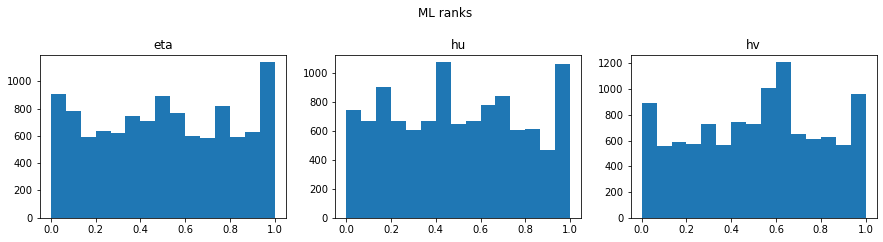

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ML ranks",y=1.1)

for i in range(3):
    axs[i].hist(np.maximum(0,np.minimum(ML_ranks[:,i],1)), bins=15)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

In [ ]:
STOP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2254814/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined

In [ ]:
# FEHLER!! NOT THE RIGHT QUANTITIES

# ranks_var = np.zeros((len(ls),3))
# for l_idx in range(len(ls)):
#     ranks_var[l_idx] = np.var(ranks_per_level[l_idx], axis=0)

# ranks_diff_var = np.zeros((len(ls)-1,3))
# for l_idx in range(1,len(ls)):
#     ranks_diff_var[l_idx-1] = np.var(diff_ranks_per_level[l_idx], axis=0)

# Nxs = (2**ls)*(2**(ls+1))
# fig, axs = plt.subplots(1,3, figsize=(15,5))
# for i in range(3):
#     axs[i].loglog(Nxs,ranks_var[:,i], label="Var[F(u^l)]")
#     axs[i].loglog(Nxs[1:],ranks_diff_var[:,i], label="Var[F(u^l+)-F(u^l-)]")
#     axs[i].legend()


In [16]:
NL = 250

# data_argsL = initLevel(ls[-1])

# stateL = np.zeros((3,nys[-1],nxs[-1],NL))
# for e in range(NL):
#     wind = wind_sample(KLSampler, T+T_forecast, wind_weight=wind_weight, wind_speed=0.0)
#     sim = CDKLM16.CDKLM16(gpu_ctx, **data_argsL, wind=wind)
#     sim.step(T)
#     stateL[:,:,:,e] = sim.download(interior_domain_only=True)
#     del sim

# np.save("dumpL.npy", stateL)

stateL = np.load("dumpL.npy")

In [19]:
ranksL = np.zeros((len(true_values),3))
for i in range(len(true_values)):
    ranksL[i] = 1/NL * np.sum(stateL[:,Hy,Hx,:] < true_values[i][:,np.newaxis], axis=1)

Text(0, 0.5, 'Ne = 250')

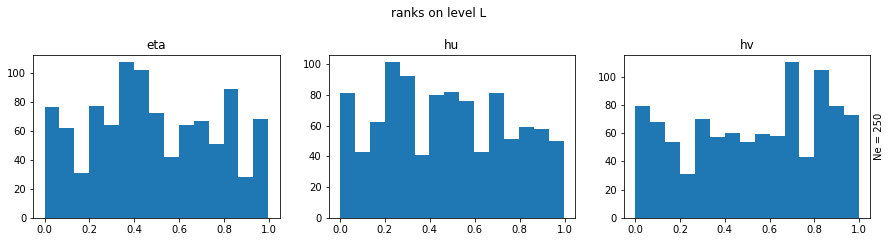

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ranks on level L",y=1.1)

for i in range(3):
    axs[i].hist(np.maximum(0,np.minimum(ranksL[:,i],1)), bins=15)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

axs[2].yaxis.set_label_position("right")
axs[2].set_ylabel("Ne = "+str(NL))


In [ ]:
STOP STOP STOP

CHECK SOME OBSERVATION ERROR NEXT! ...

NOW DO DATA ASSIMILATION AND CHECK RANKS AGAIN! ...

In [ ]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]]) 

In [ ]:
print(MLOceanEnsemble.estimate(np.mean)[:,Hy, Hx])
print(MLOceanEnsemble.estimate(np.var)[:,Hy, Hx])
np.array(MLOceanEnsemble.ML_ensemble[-1][0][0].download())[:,Hy,Hx], np.array(MLOceanEnsemble.ML_ensemble[-1][0][1].download())[:,Hy,Hx], np.array(MLOceanEnsemble.ML_ensemble[-1][0][2].download())[:,Hy,Hx]

In [ ]:
MLvar(MLOceanEnsemble.download())[:,Hy, Hx]

In [ ]:
Xs = np.linspace(0, ML_ensemble[-1][0][0].nx * ML_ensemble[-1][0][0].dx, ML_ensemble[-1][0][0].nx)
Ys = np.linspace(0, ML_ensemble[-1][0][0].ny * ML_ensemble[-1][0][0].dy, ML_ensemble[-1][0][0].ny)
X, Y = np.meshgrid(Xs, Ys)

lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), MLOceanEnsemble.download()[0][0].shape[:-1])

In [ ]:
np.var(MLOceanEnsemble.download()[0][:,obs_idxs[0],obs_idxs[1],:] , axis=1)

In [ ]:
np.var(MLOceanEnsemble.download()[0][:,obs_idxs[0],obs_idxs[1],:] , axis=1)

In [ ]:
def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var


In [ ]:
MLOceanEnsemble.ML_ensemble[0][0].t

In [ ]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)
MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 2.5*1e7, relax_factor = 1.0)
imshow3(MLOceanEnsemble.estimate(np.mean))

In [ ]:
MLOceanEnsemble.step(T_forecast)
ML_final_state = MLOceanEnsemble.download()
imshow3(MLOceanEnsemble.estimate(np.mean))

In [ ]:
fig, axs = imshow3var(MLOceanEnsemble.estimate(np.var))
axs[0].scatter(Hy, Hx)
axs[1].scatter(Hy, Hx)
axs[2].scatter(Hy, Hx)

In [ ]:
truth.step(T_forecast)

ML_Fy = MLcdf4true(truth, Hx, Hy, ML_ensemble, ML_final_state)
ML_Fy

In [ ]:
def SLcdf4true(truth, Hx, Hy, SL_ensemble, SL_final_state):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]])

    SL_Fy = np.sum(SL_final_state[:,Hy,Hx,:] < true_values[:,np.newaxis], axis=1)/SL_Ne    

    return SL_Fy

In [ ]:
SL_Fy = SLcdf4true(truth, Hx, Hy, SL_ensemble, SL_final_state)
SL_Fy